In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tools.tools import add_constant
from statsmodels.discrete.discrete_model import Logit
from tqdm import tqdm

In [6]:
data_url = "https://gitlab.inria.fr/learninglab/mooc-rr/mooc-rr-ressources/-/raw/master/module3/Practical_session/Subject6_smoking.csv?inline=false"
data_path = "mortalite_femmes_fumeuses_ou_non.csv"

import os
import urllib.request
if not os.path.exists(data_path):
    urllib.request.urlretrieve(data_url, data_path)

raw_data = pd.read_csv(data_path)
raw_data.head()

Smoker Status   Age
0    Yes  Alive  21.0
1    Yes  Alive  19.3
2     No   Dead  57.5
3     No  Alive  47.1
4    Yes  Alive  81.4

In [7]:
raw_data[raw_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [Smoker, Status, Age]
Index: []

In [8]:
tableau_croise = pd.crosstab(raw_data["Smoker"], raw_data["Status"])
tableau_croise

Status  Alive  Dead
Smoker             
No        502   230
Yes       443   139

In [9]:
taux_mortalite = tableau_croise['Dead'] / tableau_croise.sum(axis=1)
taux_mortalite

Smoker
No     0.314208
Yes    0.238832
dtype: float64

In [10]:
bins = [18, 34, 54, 64, float('inf')]  # Limites des catégories
labels = ['18-34 ans', '34-54 ans', '55-64 ans', 'plus de 65 ans']  # Noms des catégories
raw_data['Age_Category'] = pd.cut(raw_data['Age'], bins=bins, labels=labels, right=False)

# Création du tableau croisé en fonction de Smoker, Status et Age_Category
tableau_croise_age = pd.crosstab([raw_data['Smoker'], raw_data['Age_Category']], raw_data['Status'])

# Calcul du taux de mortalité par catégorie de fumeur et d'âge
taux_mortalite_age = tableau_croise_age['Dead'] / tableau_croise_age.sum(axis=1)

print("Tableau croisé :")
print(tableau_croise_age)
print("\nTaux de mortalité :")
print(taux_mortalite_age)

Tableau croisé :
Status                 Alive  Dead
Smoker Age_Category               
No     18-34 ans         213     6
       34-54 ans         180    19
       55-64 ans          80    39
       plus de 65 ans     29   166
Yes    18-34 ans         174     5
       34-54 ans         198    41
       55-64 ans          64    51
       plus de 65 ans      7    42

Taux de mortalité :
Smoker  Age_Category  
No      18-34 ans         0.027397
        34-54 ans         0.095477
        55-64 ans         0.327731
        plus de 65 ans    0.851282
Yes     18-34 ans         0.027933
        34-54 ans         0.171548
        55-64 ans         0.443478
        plus de 65 ans    0.857143
dtype: float64


In [11]:
raw_data['Death'] = raw_data['Status'].apply(lambda x: 1 if x == 'Dead' else 0)

In [12]:
 data_fumeurs = raw_data[raw_data['Smoker'] == 'Yes']
data_non_fumeurs = raw_data[raw_data['Smoker'] == 'No']

In [13]:
def logistic_regression(data):
    X = add_constant(data['Age'])  # Ajoute une constante pour l'interception
    y = data['Death']
    model = Logit(y, X)
    result = model.fit()
    return result

result_fumeurs = logistic_regression(data_fumeurs)
result_non_fumeurs = logistic_regression(data_non_fumeurs)

print("Résumé de la régression pour les fumeurs :")
print(result_fumeurs.summary())

print("\nRésumé de la régression pour les non-fumeurs :")
print(result_non_fumeurs.summary())

Optimization terminated successfully.
         Current function value: 0.412727
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.354560
         Iterations 7
Résumé de la régression pour les fumeurs :
                           Logit Regression Results                           
Dep. Variable:                  Death   No. Observations:                  582
Model:                          Logit   Df Residuals:                      580
Method:                           MLE   Df Model:                            1
Date:                Mon, 11 Nov 2024   Pseudo R-squ.:                  0.2492
Time:                        18:31:28   Log-Likelihood:                -240.21
converged:                       True   LL-Null:                       -319.94
                                        LLR p-value:                 1.477e-36
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------

In [14]:
 ages = np.linspace(raw_data['Age'].min(), raw_data['Age'].max(), 100)
X_ages = add_constant(ages)

In [15]:
# Fonction pour calculer les intervalles de confiance manuellement
def compute_confidence_interval(result, X, alpha=0.05):
    predictions = result.predict(X)
    # Calcul de l'erreur standard
    gradient = X @ result.cov_params() @ X.T
    std_error = np.sqrt(np.diag(gradient))
    
    # Calcul des intervalles de confiance (normal approx)
    z = 1.96  # Pour un intervalle de confiance de 95%
    lower_bound = predictions - z * std_error
    upper_bound = predictions + z * std_error
    return predictions, lower_bound, upper_bound

# Intervalles de confiance pour les fumeurs
pred_fumeurs, lower_fumeurs, upper_fumeurs = compute_confidence_interval(result_fumeurs, X_ages)

# Intervalles de confiance pour les non-fumeurs
pred_non_fumeurs, lower_non_fumeurs, upper_non_fumeurs = compute_confidence_interval(result_non_fumeurs, X_ages)

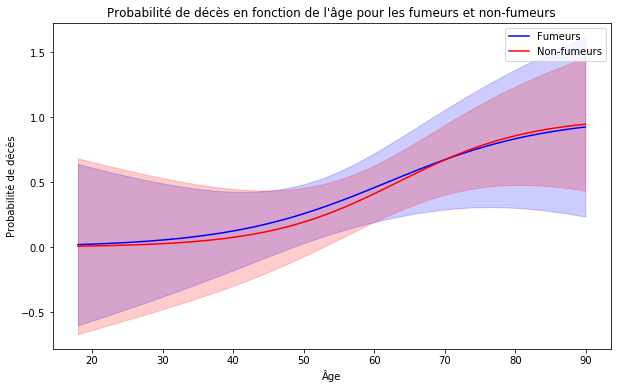

In [16]:
plt.figure(figsize=(10, 6))

# Courbe pour les fumeurs
plt.plot(ages, pred_fumeurs, color='blue', label='Fumeurs')
plt.fill_between(ages, lower_fumeurs, upper_fumeurs, color='blue', alpha=0.2)

# Courbe pour les non-fumeurs
plt.plot(ages, pred_non_fumeurs, color='red', label='Non-fumeurs')
plt.fill_between(ages, lower_non_fumeurs, upper_non_fumeurs, color='red', alpha=0.2)

plt.xlabel("Âge")
plt.ylabel("Probabilité de décès")
plt.title("Probabilité de décès en fonction de l'âge pour les fumeurs et non-fumeurs")
plt.legend()
plt.show()